<a href="https://colab.research.google.com/github/limitlin840318/data-course-sample/blob/main/sample-cf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from os.path import exists
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
sns.set_style("whitegrid")

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(nltk.corpus.stopwords.words('english'))
def content_filter(text):
    # stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in text if (w.lower() not in stop_words) & (w.isalnum()) ]
    return content

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 載入資料

In [4]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-08 11:54:45--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  19.8MB/s    in 0.7s    

2022-01-08 11:54:46 (19.8 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2022-01-08 11:54:46--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  14.0MB/s    in 0.7s    

202

In [5]:
#商品的基本資訊 metadata,購買商品的紀錄 ratings
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

## 資料整理

Step1 : Clean data

*   Convert time format

In [6]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

*   Dropout the duplicated rows
*   Parsing the `rank` column for generating `rank` and `categories`

In [7]:
# Drop duplicates rows
metadata_clean = metadata.loc[metadata.astype(str).drop_duplicates().index]

In [8]:
# 商品資訊- select useful columns
metadata_clean = metadata_clean[['asin', 'brand', 'title', 'rank','description']]

In [9]:
metadata_clean['rank'] = metadata_clean['rank'].str.replace('&amp;', '&')

# 買什麼種類商品
metadata_clean['categories'] = metadata_clean['rank'].str.split(' in ').str[1]
metadata_clean['categories'] = metadata_clean['categories'].str[:-2]

# 商品排名，轉換型別
metadata_clean['rank'] = metadata_clean['rank'].str.split(expand = True)[0].str.replace(',', '')
metadata_clean['rank'] = pd.to_numeric(metadata_clean['rank'])

In [10]:
metadata_clean['categories'].unique()

array(['Beauty & Personal Care', nan, 'Grocery & Gourmet Food',
       'Health & Household', 'Sports & Outdoors', 'Toys & Games', 'Baby',
       'Clothing, Shoes & Jewelry', 'Home & Kitchen', 'Automotive',
       'Tools & Home Improvement'], dtype=object)


*   僅使用（beauty）的類別資料



In [12]:
metadata_clean = metadata_clean[metadata_clean['categories']=='Beauty & Personal Care']

In [13]:
metadata_clean['title'] = metadata_clean['title'].str.replace('&amp;', '&')

In [14]:
metadata_clean['description'] = metadata_clean['description'].str[0].replace(np.nan, '')

*   Combine `description` and `title` to create new `desc`
*   Made `desc` string lowercase

In [15]:
metadata_clean['desc'] = metadata_clean["title"] +' '+ metadata_clean["description"]
metadata_clean['desc'] = metadata_clean['desc'].str.lower()

*   Create new attribute `asin_rating` : asin mean average rating



In [16]:
#asin mean score
asin_rating = ratings.groupby('asin')[['overall']].mean().reset_index().rename(columns={"asin": "asin", "overall": "rating_mean"})

In [17]:
metadata_clean = pd.merge(metadata_clean,asin_rating , on="asin", how="left")

In [18]:
metadata_clean.head(1)

,asin,brand,title,rank,description,categories,desc,rating_mean
0,6546546450,idea village,Loud 'N Clear&trade; Personal Sound Amplifier,2938573.0,Loud 'N Clear Personal Sound Amplifier allows ...,Beauty & Personal Care,loud 'n clear&trade; personal sound amplifier ...,2.5


In [19]:
metadata_clean = metadata_clean[['asin', 'brand', 'rank','categories','desc','rating_mean']]

# 資料切分

In [20]:
#依上次結果使用近三個月訓練資料
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
    ]

ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]

In [21]:
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 資料處理-標題 (Content-based filtering)

Step2 : Analyze the distribution of the words

*   `nltk` package is used to do:
1.   Filter out the stopwords: `content_filter(text)`
2.   Select words with occurance >1 to sufficiently represent the original text.

In [ ]:
##Cleaning data (cited from: https://github.com/phwangktw/data-course-sample/blob/main/Session2_Content_based_Recommendation_Algorithm_ipynb.ipynb)

metadata_descOnly = metadata_clean[['asin','desc']].reset_index().drop(['index'], axis=1)
metadata_descOnly['desc'] = metadata_descOnly['desc'].str.replace('&amp;', '')
wholeContent = ''
for i, a in enumerate(metadata_descOnly.desc):
    wholeContent += str(a) + ' '

In [ ]:
##TODO: filter out the numerical words (Ex. 8, 24...)
tokens = nltk.word_tokenize(wholeContent)
contentToken_filtered = content_filter(tokens)
rawBgs = nltk.ngrams(contentToken_filtered,1)
fdist = nltk.FreqDist(rawBgs)

keywordlist ={}
for k, v in fdist.items():                  
    keywordlist[k[0]] = v

In [ ]:
#keywordlist_df = pd.DataFrame.from_dict(keywordlist, orient='index').rename(columns={0:'Qunatity'})
#print(keywordlist_df[keywordlist_df['Qunatity'] == 1].index)

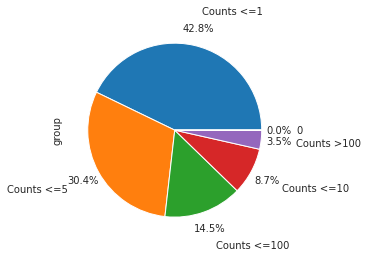

In [ ]:
#Check-purpose only
CountsDF = pd.DataFrame.from_dict(keywordlist, orient='index',columns=['Counts'])
#Control size of the keywords
CountsDF.describe()

# create a list of our conditions
conditions = [
    (CountsDF['Counts'] <= 1),
    (CountsDF['Counts'] <= 5),
    (CountsDF['Counts'] <= 10),
    (CountsDF['Counts'] <= 100),
    (CountsDF['Counts'] <= 10000)
    ]

# create a list of the values we want to assign for each condition
values = ['Counts <=1', 'Counts <=5', 'Counts <=10', 'Counts <=100', 'Counts >100']

# create a new column and use np.select to assign values to it using our lists as arguments
CountsDF['group'] = np.select(conditions, values)
CountsDF.group.value_counts().plot.pie(autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.4)
filterList = CountsDF[CountsDF['group']!='Counts <=1'].reset_index()['index'].str.lower().tolist()

In [ ]:
#Text Parsing
#Step1: Parsing title to KeyWords ONLY
keyCounts = 0
metadata_descOnly['titleNew'] = ""
for i, a in enumerate(metadata_descOnly.desc):
    a_Raw = a.split()
    resultwords  = [word for word in a_Raw if word.lower() in filterList]
    result = ' '.join(resultwords)    
    if (len(result) != 0):
        metadata_descOnly.loc[i, 'titleNew'] = result
        keyCounts += 1

keyWordCoverage = keyCounts/metadata_descOnly.shape[0]
print(f'Key words coverage: {round(keyWordCoverage, 4)}')

Key words coverage: 0.9988


99.88% of the products will "at least have 1 value" in the vectorized text vector. Although some of the information might be lost, the gain of the computational resource is more beneficial.

# Content-Based recommendation

一、Content-Based (description) + Rule-based (最近三個月內)

產生推薦
*   「描述」- tfidf矩陣
*   cosine_similarity，回傳k個最相近的物品 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
df = metadata_descOnly.drop_duplicates('titleNew')
tf = TfidfVectorizer(analyzer='word', stop_words='english')

In [ ]:
tfidf_matrix = tf.fit_transform(df['titleNew'])

In [ ]:
# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df['titleNew'])

In [ ]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

In [ ]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    # 近三個月作為沒有購買記錄使用者的推薦商品
    ratings_trainings_3m = ratings[
    (ratings['DATE'] < '2018-09-01') & (ratings['DATE'] >= '2018-06-01')
    ]

    purchased_user_list = ratings_trainings.reviewerID.tolist()
    top_ten = ratings_trainings_3m.groupby('asin').count().sort_values('overall',ascending=False).head(k).index.tolist()

    for user in users:
      if user in purchased_user_list:
        recommendations[user] = recommend_items(metadata_clean[metadata_clean['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['desc'].tolist(), k)
      else:
        recommendations[user] = top_ten
    
    return recommendations

ratings_by_user = recommender(ratings_trainings, users)

結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.13050847457627118

# CF-user-based recommendation

產生推薦

In [22]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else:
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order

    recommendation = {}
    for user in users:
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user])
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1])
                for item, _ in items_from_sim_user:
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else:
            recommendation[user] = []
    return recommendation

ratings_by_user_cf_userbased = recommender(ratings_trainings, users)
#ratings_by_user_cf_userbased

total users before filtering:  323489
total users  after filtering:  4793


結果評估

In [23]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user_cf_userbased)

0.0

# CF-Item-Based recommendation

產生推薦

In [24]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender(training_data, users=[], k=10):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

    print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

ratings_by_user_cf_itembased = recommender(ratings_trainings, users)
#ratings_by_user_cf_itembased

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

結果評估

In [25]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user_cf_itembased)

0.001694915254237288

# CF-surprise recommendation

In [31]:
pip install surprise

     |████████████████████████████████| 11.8 MB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619405 sha256=d8e94bf8e052370a4fe621730119ff5c16a35b2685afadcaa00c1b95cfb818a5
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [32]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic

In [1]:
def recommender(training_data, users=[], k=10, user_based=False, algo=KNNBasic):

    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )

    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        recommendation[user] = recommend_item_list

    return recommendation

ratings_by_user_surprise = recommender(ratings_trainings, users)
#ratings_by_user_surprise

NameError: ignored